In [1]:
from vivino_community_reviews import save_reviews, load_reviews

In [2]:
import os
import pandas as pd

def read_csv(file, path_data, **kwargs):
    """
    kwargs: keyword args for pd.read_csv
    """
    files = [x for x in os.listdir(path_data) if x.startswith(file)]

    df_reviews = pd.DataFrame()
    for f in files:
        df = pd.read_csv(f'{path_data}/{f}', **kwargs)
        df_reviews = pd.concat([df_reviews, df])

    return df_reviews.reset_index(drop=True)

# Existing

In [3]:
file = 'wine_reviews_'
df_reviews = read_csv(file, 'data')
df_reviews.groupby(['wid', 'wine']).review_transl.count().sort_index(level=1)

wid  wine                                                
4    Aguirre Dos Copas Cabernet Sauvignon                      7
0    Casillero del Diablo Cabernet Sauvignon (Reserva)       472
6    Casillero del Diablo Chardonnay (Reserva)               122
11   Cono Sur Bicicleta Reserva Unoaked Chardonnay           109
9    Frontera Cabernet Sauvignon                             207
7    Kendall-Jackson Vintner's Reserve Cabernet Sauvignon    121
10   Long Barn Chardonnay                                    142
18   Montes Montes Alpha Cabernet Sauvignon                  220
2    Roche Mazet Cuvée Spéciale Cabernet Sauvignon            61
14   Roche Mazet Cuvée Spéciale Chardonnay                    31
16   San Pedro 1865 Selected Vineyards Cabernet Sauvignon     41
17   San Pedro 1865 Single Vineyard Cabernet Sauvignon        42
3    San Pedro Gato Negro Cabernet Sauvignon                 879
13   San Pedro Gato Negro Chardonnay                         230
5    The 7th Generation - G7 Cab

# Scraping

In [4]:
from vivino_community_reviews import vivino_reviews, concat_reviews

import pandas as pd

In [5]:
locator_ratings = "//a[@href='#all_reviews']"
locator_more = "//button[@tabindex='0']"
locator_recent = '//*[@data-testid="baseModalBackdrop"]/div[2]/div[2]/div[2]/div/a[1]'

locator_review = "communityReview__reviewText--2bfLj"
locator_date = "anchor_anchor__m8Qi- reviewAnchor__anchor--2NKFw reviewDate__reviewDate--49vpM undefined"

kwargs = {
    'loc1': locator_ratings,
    'loc2': locator_more,
    'loc3': locator_recent, 
    'loc4': locator_review,
    'loc5': locator_date
}

In [6]:
kwargs.update({
    'end_date': '20220101',
    'source': 'vivino',
    #'max_scr': 10, 'time_scr': 2, 'check_idx': 4
})

## wine list

In [6]:
w = """
Kendall-Jackson Vintner's Reserve Cabernet Sauvignon
https://www.vivino.com/kendall-jackson-vintner-s-reserve-cabernet-sauvignon/w/2140?ref=nav-search#all_reviews
Viña Santa Helena Reservado Cabernet Sauvignon'
https://www.vivino.com/vina-santa-helena-central-valley-reservado-cabernet-sauvignon/w/1134409?ref=nav-search#all_reviews
Frontera Cabernet Sauvignon
https://www.vivino.com/cl-frontera-cabernet-sauvignon/w/1135072?ref=nav-search#all_reviews
Long Barn Chardonnay
https://www.vivino.com/long-barn-chardonnay/w/3980079?ref=nav-search#all_reviews
Cono Sur Bicicleta Reserva Unoaked Chardonnay
https://www.vivino.com/cono-sur-santiago-bicicleta-reserva-unoaked-chardonnay-central-valley/w/6467244?ref=nav-search#all_reviews
The 7th Generation - G7 Chardonnay
https://www.vivino.com/the-7th-generation-chardonnay/w/1577653#all_reviews
San Pedro Gato Negro Chardonnay
https://www.vivino.com/san-pedro-central-valley-vspt-gato-negro-chardonnay/w/5956#all_reviews
Roche Mazet Cuvée Spéciale Chardonnay
https://www.vivino.com/fr-roche-mazet-cuvee-speciale-chardonnay/w/2332011?ref=nav-search#all_reviews
Yellow Tail Chardonnay
https://www.vivino.com/yellow-tail-chardonnay/w/2546?ref=nav-search#all_reviews
San Pedro 1865 Selected Vineyards Cabernet Sauvignon
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-selected-vineyards-cabernet-sauvignon/w/6158938?ref=nav-search#all_reviews
San Pedro 1865 Single Vineyard Cabernet Sauvignon
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-single-vineyard-cabernet-sauvignon/w/5900?ref=nav-search#all_reviews
Montes Montes Alpha Cabernet Sauvignon
https://www.vivino.com/montes-casablanca-valley-montes-alpha-cabernet-sauvignon/w/71294?ref=nav-search#all_reviews
"""

In [7]:
w = """
Montes Montes Alpha Merlot
https://www.vivino.com/montes-casablanca-valley-montes-alpha-merlot/w/71324?ref=nav-search
Montes Montes Alpha Syrah
https://www.vivino.com/montes-casablanca-valley-montes-alpha-syrah-colchagua-valley/w/10479900?ref=nav-search
San Pedro 1865 Selected Vineyards Syrah
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-selected-vineyards-syrah-cachapoal/w/6371004
San Pedro 1865 Single Vineyard Malbec
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-single-vineyard-malbec/w/1227330
San Pedro 1865 Single Vineyard Syrah
https://www.vivino.com/san-pedro-central-valley-vspt-eighteen-sixtyfive-single-vineyard-syrah/w/1226644
Mollydooker The Boxer Shiraz
https://www.vivino.com/mollydooker-winery-the-boxer-shiraz/w/950?ref=nav-search
William Hill North Coast Cabernet Sauvignon
https://www.vivino.com/william-hill-north-coast-cabernet-sauvignon-north-coast/w/2198238
William Hill North Coast Chardonnay
https://www.vivino.com/william-hill-north-coast-chardonnay-north-coast-white-wine-v-ihqmt/w/4609184?ref=nav-search
Kendall-Jackson Vintner's Reserve Chardonnay
https://www.vivino.com/kendall-jackson-vintner-s-reserve-chardonnay/w/2132?ref=nav-search
Bread & Butter Pinot Noir
https://www.vivino.com/bread-and-butter-pinot-noir/w/1724151?ref=nav-search
Bread & Butter Cabernet Sauvignon
https://www.vivino.com/bread-and-butter-cabernet-sauvignon-california-red-wine/w/6218579?ref=nav-search
"""

In [8]:
w = w.strip('\n').split('\n')
wines = {w[i]:w[i+1] for i in range(0, len(w), 2)}

id_start = df_reviews.wid.max() + 1
id_start

19

In [9]:
# testing
idx = 2
#wines = {x[0]:x[1] for i,x in enumerate(wines.items()) if i >= idx}

**load if the reviewsof the wines not translated yet**

In [7]:
#files = []
files = ['wine_6']
path = 'data'

df_reviews = pd.DataFrame()
for f in files:
    df = load_reviews(f'{f}.csv', path=path)
    df_reviews = pd.concat([df_reviews, df])

# check duplicate wid
df_reviews.groupby('wid').wine.unique()

data/wine_6.csv loaded.


wid
6    [Casillero del Diablo Chardonnay (Reserva)]
Name: wine, dtype: object

**reset dataframe if no reviews**

In [10]:
df_reviews = pd.DataFrame()

In [13]:
# run if any wine failed
#wines = wines_failed

In [16]:
col_rev = ['wid', 'wine', 'date', 'review', 'source']
path = 'data'
wines_failed = dict()

#for wine_name, wine_url in wines:
for wine_name, wine_url in wines.items():
    try:
        df = vivino_reviews(wine_url, wine_name, **kwargs)
        df_reviews = concat_reviews(df_reviews, df, wine_name, col_rev, path=path, id_start=id_start)
    except:
        print(f'ERROR: check {wine_name}')
        wines_failed.update({wine_name: wine_url})

print(f'num of failed: {len(wines_failed)}')

53it [00:19,  2.77it/s]


53 reviews collected.
data/wine_25.csv saved.


53it [00:34,  1.53it/s]


53 reviews collected.
data/wine_26.csv saved.


563it [15:40,  1.67s/it]


563 reviews collected.
data/wine_27.csv saved.


1253it [1:01:56,  2.97s/it]


1253 reviews collected.
data/wine_28.csv saved.


33it [00:31,  1.05it/s]

data/wine_29.csv saved.
num of failed: 0


In [18]:
df_reviews

,wid,wine,date,review,source
0,19,Montes Montes Alpha Merlot,2024-02-05,Enjoyed it with chicken tikka masala as its so...,vivino
1,19,Montes Montes Alpha Merlot,2023-12-31,"Vintage 2021 very smooth, Well balanced with v...",vivino
2,19,Montes Montes Alpha Merlot,2023-11-26,oak plum tobacco Slightly bitter Worth of pric...,vivino
3,19,Montes Montes Alpha Merlot,2023-11-24,.,vivino
4,19,Montes Montes Alpha Merlot,2023-11-23,easy to drink table top merlot. it does not pr...,vivino
...,...,...,...,...,...
28,29,Bread & Butter Cabernet Sauvignon,2023-12-22,Ok but oakey,vivino
29,29,Bread & Butter Cabernet Sauvignon,2023-12-21,Wedding wine 🩷,vivino
30,29,Bread & Butter Cabernet Sauvignon,2021-08-30,,vivino
31,29,Bread & Butter Cabernet Sauvignon,2022-03-07,Mielzynski. Lovely cab sav from Napa. Very fru...,vivino


**temp saving before translation**

In [20]:
df_reviews.groupby(['wid', 'wine']).review.count().sort_index(level=1)

wid  wine                                        
29   Bread & Butter Cabernet Sauvignon                 33
28   Bread & Butter Pinot Noir                       1253
27   Kendall-Jackson Vintner's Reserve Chardonnay     563
24   Mollydooker The Boxer Shiraz                     283
19   Montes Montes Alpha Merlot                        63
20   Montes Montes Alpha Syrah                         83
21   San Pedro 1865 Selected Vineyards Syrah           13
22   San Pedro 1865 Single Vineyard Malbec             13
23   San Pedro 1865 Single Vineyard Syrah              13
25   William Hill North Coast Cabernet Sauvignon       53
26   William Hill North Coast Chardonnay               53
Name: review, dtype: int64

In [22]:
save_reviews(df_reviews, 'wine_reviews_tmp.csv', 'data')

data/wine_reviews_tmp.csv saved.


# Review data

In [14]:
df_reviews = load_reviews('wine_reviews_tmp.csv', 'data')

data/wine_reviews.csv loaded.


In [23]:
cond = (df_reviews.date.isna()) | (df_reviews.review.isna())
df_reviews.loc[cond]

,wid,wine,date,review,source
60,19,Montes Montes Alpha Merlot,NaT,,vivino
80,20,Montes Montes Alpha Syrah,NaT,,vivino
10,23,San Pedro 1865 Single Vineyard Syrah,NaT,,vivino
50,25,William Hill North Coast Cabernet Sauvignon,NaT,,vivino
50,26,William Hill North Coast Chardonnay,NaT,,vivino


In [24]:
df_reviews = df_reviews.loc[~cond].reset_index(drop=True)

In [25]:
df_reviews.date.dt.year.value_counts().sort_index(ascending=False)

date
2024     148
2023     910
2022    1232
2021     110
2020      12
2019       3
2018       1
2016       2
Name: count, dtype: int64

In [26]:
kwargs['end_date']

'20220101'

<Axes: >

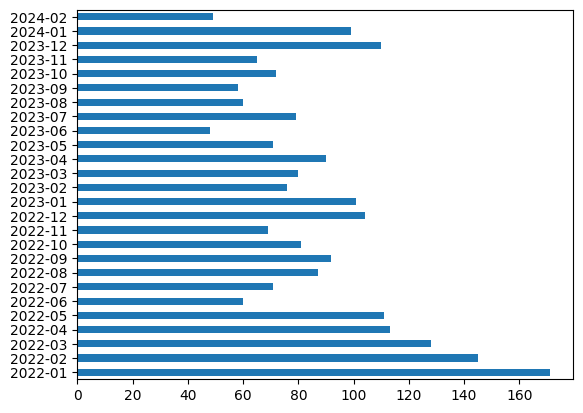

In [27]:
#d = df_reviews.date.agg(['min', 'max']).to_list()
d = [kwargs['end_date'], df_reviews.date.max()]

date_range = pd.date_range(start=d[0], end=d[1]).to_period("M").unique()

(df_reviews
 .set_index('date').to_period("M")
 .groupby(level=0).review.count()
 .sort_index()
 .reindex(date_range, fill_value=0)
 .plot(kind='barh')
)

<Axes: ylabel='wine'>

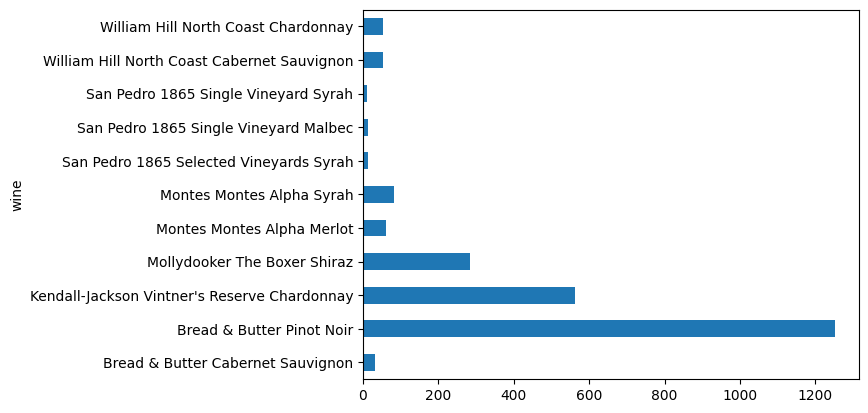

In [28]:
(df_reviews
 .groupby(by='wine').review.count()
 .plot(kind='barh')
)

In [29]:
df_reviews.head()

,wid,wine,date,review,source
0,19,Montes Montes Alpha Merlot,2024-02-05,Enjoyed it with chicken tikka masala as its so...,vivino
1,19,Montes Montes Alpha Merlot,2023-12-31,"Vintage 2021 very smooth, Well balanced with v...",vivino
2,19,Montes Montes Alpha Merlot,2023-11-26,oak plum tobacco Slightly bitter Worth of pric...,vivino
3,19,Montes Montes Alpha Merlot,2023-11-24,.,vivino
4,19,Montes Montes Alpha Merlot,2023-11-23,easy to drink table top merlot. it does not pr...,vivino


# Translate

In [30]:
import langdetect
import json
from deep_translator import GoogleTranslator
from tqdm import tqdm

def detect_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

def get_translation(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

In [31]:
tmp_data = []

for rec in tqdm(df_reviews.to_dict('records')):
    tmp_data.append({
        #'wid': rec['wid'],
        'lang': detect_language(rec['review']),
        'review_transl': get_translation(rec['review'])
    })

100%|███████████████████████████████████████████████████████████| 2418/2418 [21:46<00:00,  1.85it/s]


In [32]:
df_reviews = df_reviews.merge(pd.DataFrame(tmp_data), left_index=True, right_index=True)
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl
0,19,Montes Montes Alpha Merlot,2024-02-05,Enjoyed it with chicken tikka masala as its so...,vivino,en,Enjoyed it with chicken tikka masala as its so...
1,19,Montes Montes Alpha Merlot,2023-12-31,"Vintage 2021 very smooth, Well balanced with v...",vivino,en,"Vintage 2021 very smooth, Well balanced with v..."
2,19,Montes Montes Alpha Merlot,2023-11-26,oak plum tobacco Slightly bitter Worth of pric...,vivino,en,oak plum tobacco Slightly bitter Worth of pric...
3,19,Montes Montes Alpha Merlot,2023-11-24,.,vivino,<-- ERROR -->,None
4,19,Montes Montes Alpha Merlot,2023-11-23,easy to drink table top merlot. it does not pr...,vivino,en,easy to drink table top merlot. it does not pr...


**check translation error**

In [34]:
cond = df_reviews.lang.str.contains('ERROR')
df_reviews.loc[cond]

,wid,wine,date,review,source,lang,review_transl
3,19,Montes Montes Alpha Merlot,2023-11-24,.,vivino,<-- ERROR -->,None
54,19,Montes Montes Alpha Merlot,2020-12-31,4,vivino,<-- ERROR -->,4
105,20,Montes Montes Alpha Syrah,2024-01-30,🇨🇱,vivino,<-- ERROR -->,None
261,24,Mollydooker The Boxer Shiraz,2023-03-03,2020,vivino,<-- ERROR -->,2020
295,24,Mollydooker The Boxer Shiraz,2022-12-19,♡♡♡,vivino,<-- ERROR -->,None
372,24,Mollydooker The Boxer Shiraz,2022-04-25,"4,7",vivino,<-- ERROR -->,"4,7"
389,24,Mollydooker The Boxer Shiraz,2022-03-27,,vivino,<-- ERROR -->,
399,24,Mollydooker The Boxer Shiraz,2022-03-06,,vivino,<-- ERROR -->,
408,24,Mollydooker The Boxer Shiraz,2022-02-23,👍,vivino,<-- ERROR -->,None
455,24,Mollydooker The Boxer Shiraz,2021-12-24,😍😍😍,vivino,<-- ERROR -->,None


In [ ]:
cond = df_reviews.review_transl.isna()
df_reviews.loc[cond]

In [35]:
df_reviews = df_reviews.loc[~cond]

**save final data**

In [36]:
from datetime import datetime
d = datetime.today().strftime('%y%m%d')
save_reviews(df_reviews, f'wine_reviews_{d}.csv')

data/wine_reviews_240212.csv saved.


In [40]:
!unzip -l wine_reviews.zip

Archive:  wine_reviews.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
   343369  2024-02-07 16:58   wine_reviews_240124.csv
   334512  2024-02-07 18:16   wine_reviews_240207.csv
   529775  2024-02-12 20:13   wine_reviews_240212.csv
---------                     -------
  1207656                     3 files


In [39]:
!zip -uj wine_reviews.zip data/wine_reviews_2*csv

  adding: wine_reviews_240212.csv (deflated 73%)


In [31]:
#!zip -j wine_reviews.zip data/wine_reviews_2*csv

  adding: wine_reviews_240124.csv (deflated 70%)
  adding: wine_reviews_240207.csv (deflated 69%)
